In [146]:
#!pip install tensorflow==2.5.0
#!pip install tensorflow-hub==0.12.0

## Imports

In [147]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import os
import sys
from os.path import exists
from scipy import spatial

## Settings

In [148]:
im1_dir = '/home/drevital/pallet_detection/feb23_task_test_1'
im1_name = '12_02_23_data_08_JP_LD.png'
search_dir = '/home/drevital/pallet_detection/feb23_task_test_1'
sims_base_path = '/home/drevital/obstacles_classification_datasets/src_base_dataset/sim10'
sims_saved_path = '_'.join(search_dir.split('/')[4:])
sims_path = os.path.join(sims_base_path, sims_saved_path)
Path(sims_path).mkdir(parents=True, exist_ok=True)
features_path = os.path.join(sims_path, 'features.csv')
im_height = 200
im_width = 600
sim_thresh = 0.9
max_sim = -1
most_sim = None
most_sim_dist = 0

## Read Image

In [149]:
im1 = tf.io.read_file(os.path.join(im1_dir, im1_name))
im1 = tf.io.decode_jpeg(im1, channels=3)
im1_src = im1
im1 = tf.image.resize_with_pad(im1, 224, 224)
# Convert to shape (1, 224, 224, 3) float
im1  = tf.image.convert_image_dtype(im1, tf.float32)[tf.newaxis, ...]

## Load the MobileNet Module

In [150]:
module_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4'
module = hub.load(module_handle)

## Calculate the compared image's features vector

In [151]:
f1 = module(im1)   
f1_set = np.squeeze(f1)

In [152]:
f1_set.shape

(1792,)

## Prepare compared images for features_calc and similarity search

In [153]:
sim_names = []
sim_scores = []
fnames = os.listdir(search_dir)
most_sim_name = None
feature_vecs = {}
np.set_printoptions(threshold=sys.maxsize)

In [154]:
features_path

'/home/drevital/obstacles_classification_datasets/src_base_dataset/sim10/feb23_task_test_1/features.csv'

## Calculate and store all compared directories's images' feature-vectors

In [155]:
feature_vecs = {}
i=0

if not exists(features_path):
    for fname in tqdm(fnames):
        impath = os.path.join(search_dir, fname)
        im = tf.io.read_file(impath)
        im = tf.io.decode_jpeg(im, channels=3)
        im = tf.image.resize_with_pad(im, 224, 224)
        # Convert to shape (1, 224, 224, 3) float
        im  = tf.image.convert_image_dtype(im, tf.float32)[tf.newaxis, ...]
        f = module(im)   
        f_set = np.squeeze(f)  
        feature_vecs[i] = {'path': impath, 'features': f_set}
        i += 1
        
    features_df = pd.DataFrame.from_dict(feature_vecs).transpose() 
    features_df.to_csv(features_path, sep=',')

100%|██████████| 10/10 [00:00<00:00, 17.36it/s]


## Search for Similarities

In [156]:
features_df = pd.read_csv(features_path, delimiter=',')

for fname in tqdm(fnames):
    im2_path = os.path.join(search_dir, fname)
    row = features_df[features_df['path'] == im2_path]
    f2_set = [float(item) for item in row['features'].tolist()[0][1:-1].split()]
    similarity = 1 - spatial.distance.cosine(f1_set, f2_set)
    if similarity >= sim_thresh:
        sim_names.append(fname)
        sim_scores.append(similarity)
        if similarity > max_sim:
            max_sim = similarity
            most_sim_name = fname

100%|██████████| 10/10 [00:00<00:00, 870.51it/s]


In [157]:
sim_scores

[0.9999999461963462,
 0.9181629398256244,
 0.9177116490207059,
 0.9694854890637374]

In [158]:
len(sim_names), len(sim_scores)

(4, 4)

## Write similar images to output directory

In [159]:
saved_dir = '_'.join(im1_name.split('_')[:2]) + '__' + str(sim_thresh)
saved_path = os.path.join(sims_path, saved_dir)
Path(saved_path).mkdir(parents=True, exist_ok=True)

for i, fname in enumerate(sim_names):    
    impath = os.path.join(search_dir, fname)
    im = cv2.imread(impath)
    prefix = '_'.join(fname.split('_')[:2])
    imname = f'{prefix}_{sim_scores[i]:.3f}.jpg'
    cv2.imwrite(os.path.join(saved_path, imname), im)

In [160]:
max_sim, most_sim_name

(0.9999999461963462, '12_02_23_data_08_JP_LD.png')

## Display Compared Image

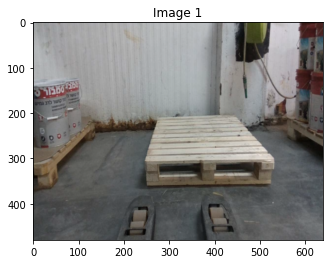

In [161]:
im1 = cv2.cvtColor(im1_src.numpy(), cv2.COLOR_RGB2RGBA)
plt.imshow(im1)
plt.title('Image 1')
plt.show() 